# Plotting Average T using 1 degree experiment practice

Example of how to plot the average temperature above 1km depth using mask around Antarctica using experiment from Ideg_jra55_ryf9091_gadi.

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:44329 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 31.21 GiB


Start a session in the default COSIMA database. To search this database, the following commands can be used:

e.g.: search for all the `1deg` experiments

```python
exp = cc.querying.get_experiments(session)
exp[exp['experiment'].str.lower().str.match('1deg')]
```

## Start a Cosima cookbook database session

In [3]:
# From file of "Exploring the COSIMA Cookbook"
from cosima_cookbook import explore

In [4]:
# Load database
session = cc.database.create_session()

In [5]:
dbx = explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

## Loading in ht and temp data

In [6]:
# dates to match the record
start_time = '1999-12-31'
end_time = '2399-12-31'

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp = cc.querying.getvar(expt='1deg_jra55_ryf9091_gadi', variable='temp', 
                          session=session, start_time=start_time, end_time=end_time, frequency='1 yearly') - 273.15
ht = cc.querying.getvar(expt='1deg_jra55_ryf9091_gadi', variable='ht', 
                          session=session, frequency='static', n=1)

# Select latitude range:
temp = temp.sel(yt_ocean = slice(lat_min, lat_max))
ht = ht.sel(yt_ocean = slice(lat_min, lat_max))

# Select surface ocean:
temp_surface = temp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m = temp.sel(st_ocean=250, method='nearest')
# Weighted average with all depths
weights_st = salt.st_ocean
temp_st = temp.weighted(weights_st).mean('st_ocean')

temp_st = temp.mean('st_ocean') 

isn’t actually doing an exact mean. This is something slightly deceptive about xarray. It is actually just doing the mean of the values contained in the vector — in other words, it assumes that all cells are the thickness. In ACCESS-OM2, the cells vary in thickness, so .mean() actually places more emphasis on surface temperature than it should.

The way around this is to use a weighted mean:

http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

There is a cookbook example which explains more about this problem:

https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/True_Zonal_Mean.ipynb

## Masking shelf regions

In [8]:
#Advice from the PhD student of the office on how to find the latitude where depth = 1km
# Information about ht
ht = ht.load()
ht

#Find the latitude of sea floor depth at 1km
np.where(ht.sel(xt_ocean=70, method='nearest')>1000)[0][0]

np.where(ht.sel( method='nearest')>1000)[0]

array([ 3,  4,  6, ..., 42, 42, 42])

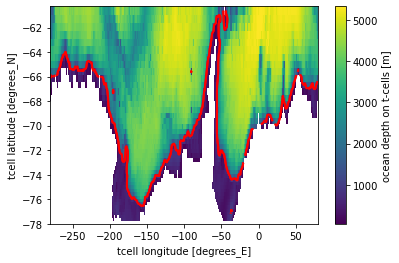

In [9]:
#Plotting ht with the 1km depth shelf boundary line to check
ht.plot()
ht.plot.contour(levels=[1000,1001],linewidths=2,colors='r')

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

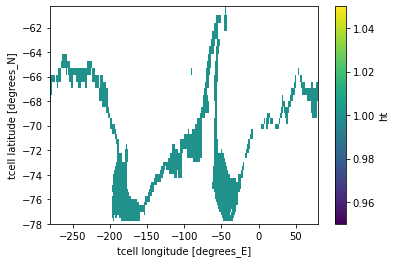

In [10]:
land_mask = ~ht.isnull()

#mask the area for ht < 1 km around the coast 
fig=plt.figure()
ax = plt.subplot()
shelf_mask = (land_mask.where(ht < 1000))
shelf_mask.plot()

In [11]:
#Put temperature into the shelf mask
temp_shelf = temp*shelf_mask

temp_st_shelf = temp_st*shelf_mask

temp_surface_shelf = temp_surface*shelf_mask
#or temp_surface_shelf = temp.sel(st_ocean=0, method='nearest')*shelf_mask
temp_250m_shelf = temp_250m*shelf_mask
#or temp_surface_shelf = temp.sel(st_ocean=250, method='nearest')*shelf_mask

## Plotting unweighted and weighted mean Antarctic timeseries and masked example at the beginning

Text(0, 0.5, 'Latitude (degrees N)')

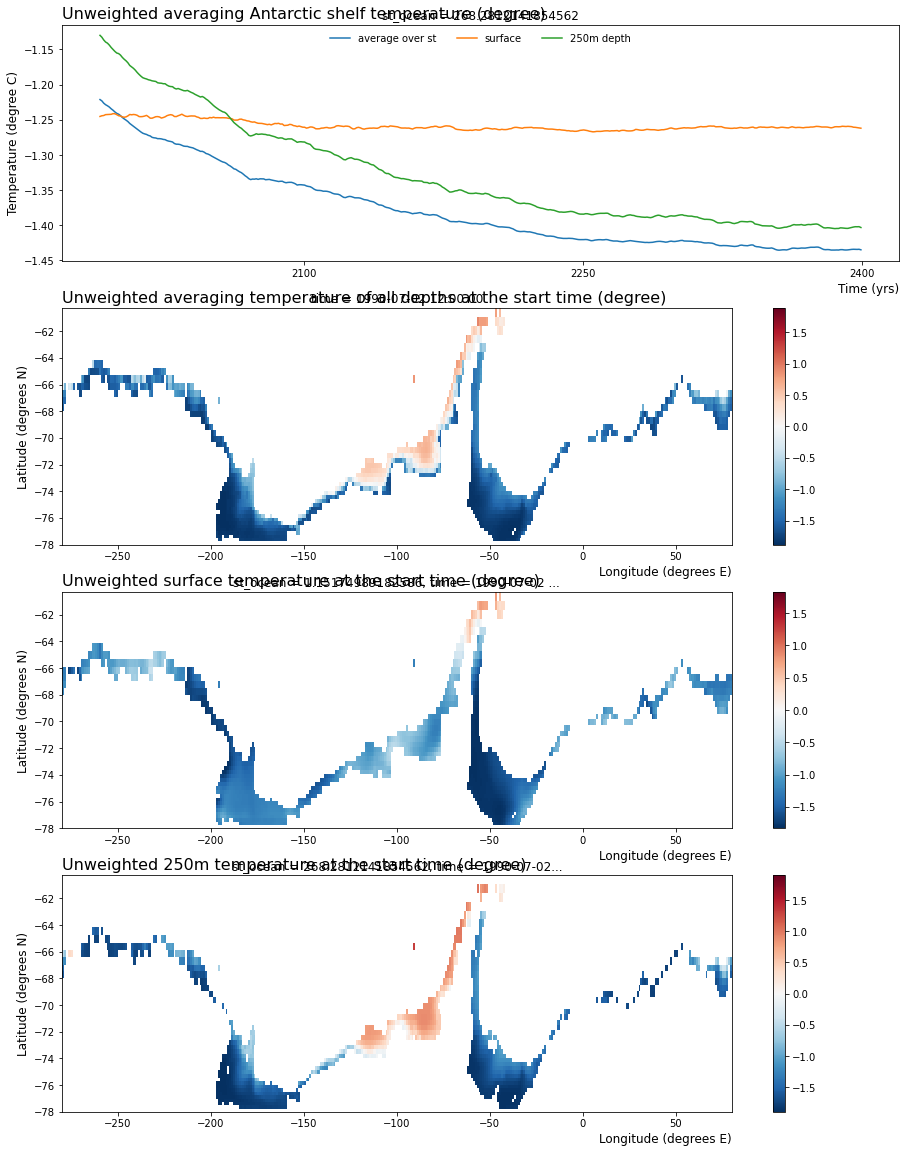

In [12]:
fig = plt.figure(figsize=(15, 20))

#Plotting unweighted Antarctic mean shelf temperature at surface, 250m and averaging over all depths
plt.subplot(4,1,1)
plt.title('Unweighted averaging Antarctic shelf temperature (degree)', fontsize=16, loc='left')
temp_st_shelf.mean(("xt_ocean", "yt_ocean")).plot(label='average over st')
temp_surface_shelf.mean(("xt_ocean", "yt_ocean")).plot(label='surface')
temp_250m_shelf.mean(("xt_ocean", "yt_ocean")).plot(label='250m depth')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
#plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.legend(frameon=False, loc='upper center', ncol=3)

#Mask of averaging temperature over all depths at the start time
plt.subplot(4,1,2)
plt.title('Unweighted averaging temperature of all depths at the start time (degree)', fontsize=16, loc='left')
temp_st_shelf.isel(time=0).plot()
plt.xlabel('Longitude (degrees E)', fontsize=12, loc='right')
plt.ylabel('Latitude (degrees N)', fontsize=12)

#Mask of surface temperature at the start time
plt.subplot(4,1,3)
plt.title('Unweighted surface temperature at the start time (degree)', fontsize=16, loc='left')
temp_surface_shelf.isel(time=0).plot()
plt.xlabel('Longitude (degrees E)', fontsize=12, loc='right')
plt.ylabel('Latitude (degrees N)', fontsize=12)

#Mask of surface temperature at the start time
plt.subplot(4,1,4)
plt.title('Unweighted 250m temperature at the start time (degree)', fontsize=16, loc='left')
temp_250m_shelf.isel(time=0).plot()
plt.xlabel('Longitude (degrees E)', fontsize=12, loc='right')
plt.ylabel('Latitude (degrees N)', fontsize=12)

Each grid cell also has a different spatial area (see cookbook example above) which means that area averages are also slightly inaccurate. 

The way around this is to use a weighted mean:

http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

In [13]:
weights = np.cos(np.deg2rad(temp.yt_ocean))
temp_weighted = temp.weighted(weights)
weighted_mean = temp_weighted.mean(("xt_ocean", "yt_ocean"))

temp_st_shelf_weighted = temp_st_shelf.weighted(weights)
temp_surface_shelf_weighted = temp_surface_shelf.weighted(weights)
temp_250m_shelf_weighted = temp_250m_shelf.weighted(weights)

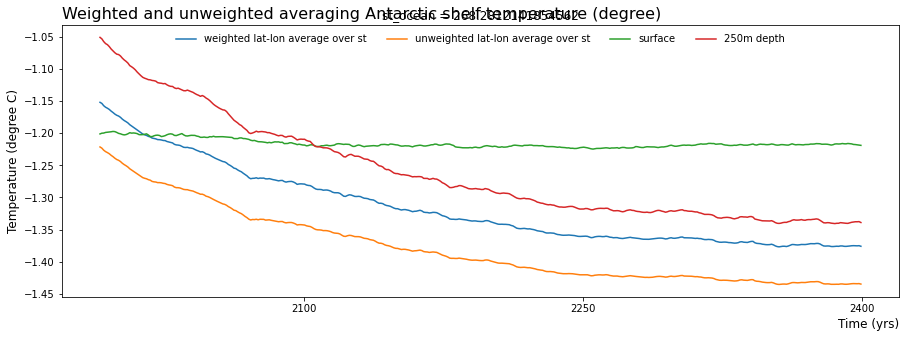

In [14]:
#Plotting Antarctic mean shelf temperature at surface, 250m and averaging over all depths
fig = plt.figure(figsize=(15, 5))
plt.title('Weighted and unweighted averaging Antarctic shelf temperature (degree)', fontsize=16, loc='left')
temp_st_shelf.mean("st_ocean").mean(("xt_ocean", "yt_ocean")).plot(label='unweighted lat-lon average over st')
temp_st_shelf.mean(("xt_ocean", "yt_ocean")).plot(label='weighted lat-lon average over st')
temp_surface_shelf_weighted.mean(("xt_ocean", "yt_ocean")).plot(label='surface')
temp_250m_shelf_weighted.mean(("xt_ocean", "yt_ocean")).plot(label='250m depth')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
#plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.legend(frameon=False, loc='upper center', ncol=4)

The weighted averages are more accurate, which will be used thereafter.

# Region selection

## Weddell Sea coastal polynyas shelf region

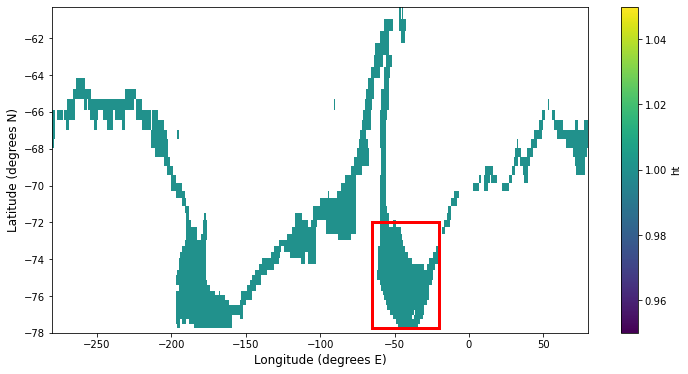

In [15]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

bottomleft_lon=-65
bottomleft_lat=-77.75
topright_lon=-20
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

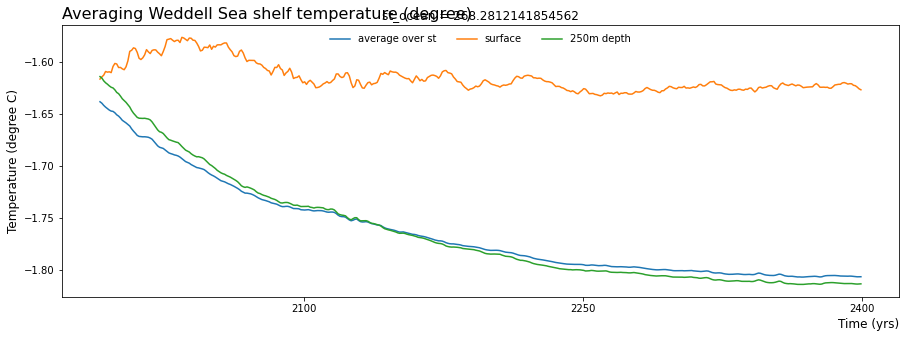

In [16]:
temp_shelf_Weddell = temp_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_shelf_Weddell_weighted = temp_shelf_Weddell.weighted(weights_st).mean('st_ocean')
temp_st_shelf_Weddell = temp_shelf_Weddell_weighted.weighted(weights)
temp_surface_shelf_Weddell = temp_shelf_Weddell.sel(st_ocean=0, method='nearest').weighted(weights)
temp_250m_shelf_Weddell = temp_shelf_Weddell.sel(st_ocean=250, method='nearest').weighted(weights)

fig = plt.figure(figsize=(15, 5))

#Plotting mean shelf temperature at surface, 250m and averaging over all depths
plt.title('Averaging Weddell Sea shelf temperature (degree)', fontsize=16, loc='left')
temp_st_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='average over st')
temp_surface_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='surface')
temp_250m_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='250m depth')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
#plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.legend(frameon=False, loc='upper center', ncol=3)

## Ross Sea coastal polynya shelf region

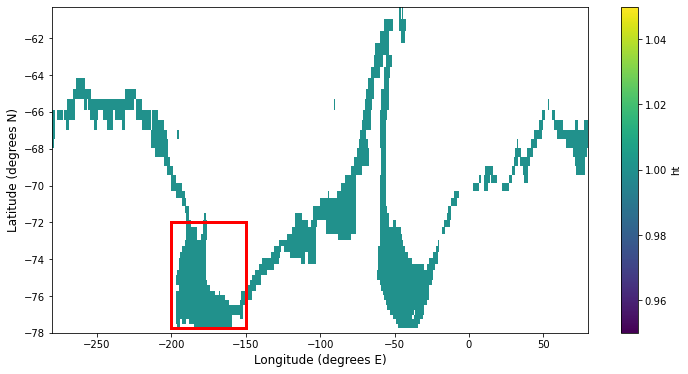

In [17]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

bottomleft_lon=-200
bottomleft_lat=-77.75
topright_lon=-150
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

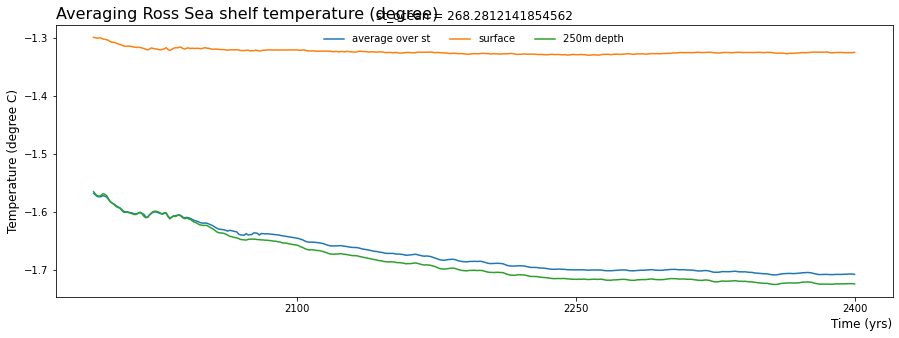

In [18]:
temp_shelf_Ross = temp_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_st_shelf_Ross_weighted = temp_shelf_Ross.weighted(weights_st).mean('st_ocean')
temp_st_shelf_Ross = temp_st_shelf_Ross_weighted.weighted(weights)
temp_surface_shelf_Ross = temp_shelf_Ross.sel(st_ocean=0, method='nearest').weighted(weights)
temp_250m_shelf_Ross = temp_shelf_Ross.sel(st_ocean=250, method='nearest').weighted(weights)

fig = plt.figure(figsize=(15, 5))

#Plotting mean shelf temperature at surface, 250m and averaging over all depths
plt.title('Averaging Ross Sea shelf temperature (degree)', fontsize=16, loc='left')
temp_st_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='average over st')
temp_surface_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='surface')
temp_250m_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='250m depth')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
#plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.legend(frameon=False, loc='upper center', ncol=3)

## Cape Darnley polynya shelf region

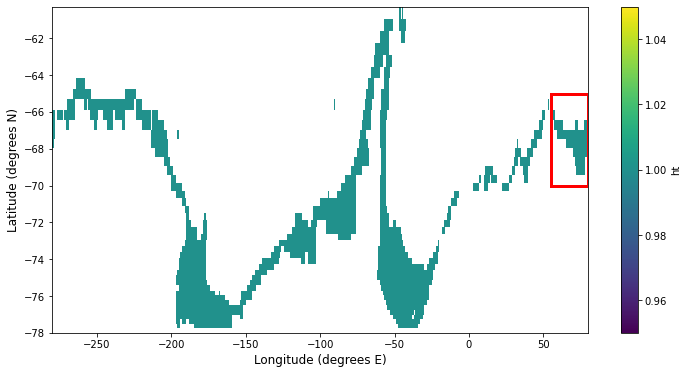

In [19]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

bottomleft_lon=55
bottomleft_lat=-70
topright_lon=80
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

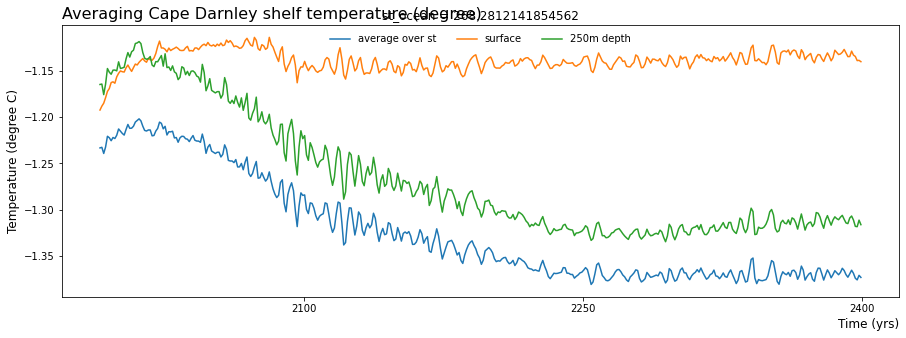

In [20]:
temp_shelf_CapeD = temp_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_st_shelf_CapeD_weighted = temp_shelf_CapeD.weighted(weights_st).mean('st_ocean')
temp_st_shelf_CapeD = temp_st_shelf_CapeD_weighted.weighted(weights)
temp_surface_shelf_CapeD = temp_shelf_CapeD.sel(st_ocean=0, method='nearest').weighted(weights)
temp_250m_shelf_CapeD = temp_shelf_CapeD.sel(st_ocean=250, method='nearest').weighted(weights)

fig = plt.figure(figsize=(15, 5))

#Plotting mean shelf temperature at surface, 250m and averaging over all depths
plt.title('Averaging Cape Darnley shelf temperature (degree)', fontsize=16, loc='left')
temp_st_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='average over st')
temp_surface_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='surface')
temp_250m_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='250m depth')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
#plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.legend(frameon=False, loc='upper center', ncol=3)

## Mertz Glacier Polynya shelf region

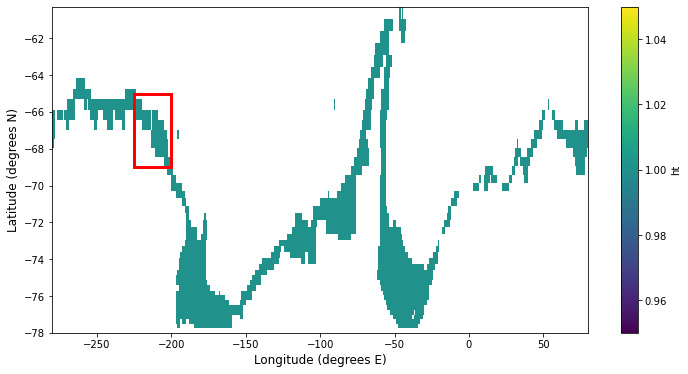

In [21]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

bottomleft_lon=-225
bottomleft_lat=-69
topright_lon=-200
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

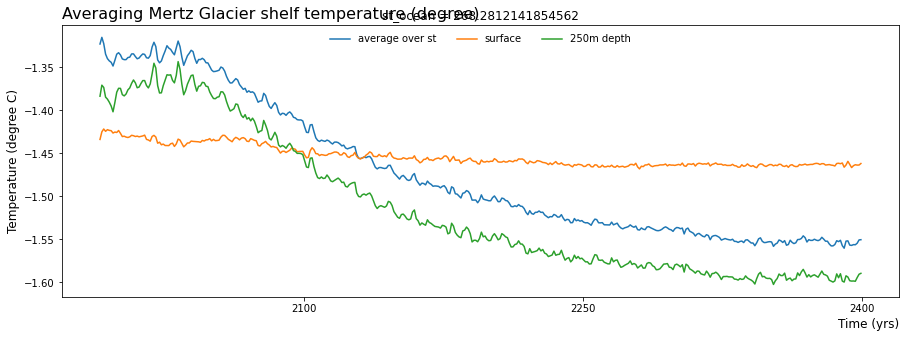

In [22]:
temp_shelf_Mertz = temp_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_st_shelf_Mertz_weighted = temp_shelf_Mertz.weighted(weights_st).mean('st_ocean')
temp_st_shelf_Mertz = temp_st_shelf_Mertz_weighted.weighted(weights)
temp_surface_shelf_Mertz = temp_shelf_Mertz.sel(st_ocean=0, method='nearest').weighted(weights)
temp_250m_shelf_Mertz = temp_shelf_Mertz.sel(st_ocean=250, method='nearest').weighted(weights)

fig = plt.figure(figsize=(15, 5))

#Plotting mean shelf temperature at surface, 250m and averaging over all depths
plt.title('Averaging Mertz Glacier shelf temperature (degree)', fontsize=16, loc='left')
temp_st_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='average over st')
temp_surface_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='surface')
temp_250m_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='250m depth')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
#plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.legend(frameon=False, loc='upper center', ncol=3)

## Comparison between polynyas shelf region

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


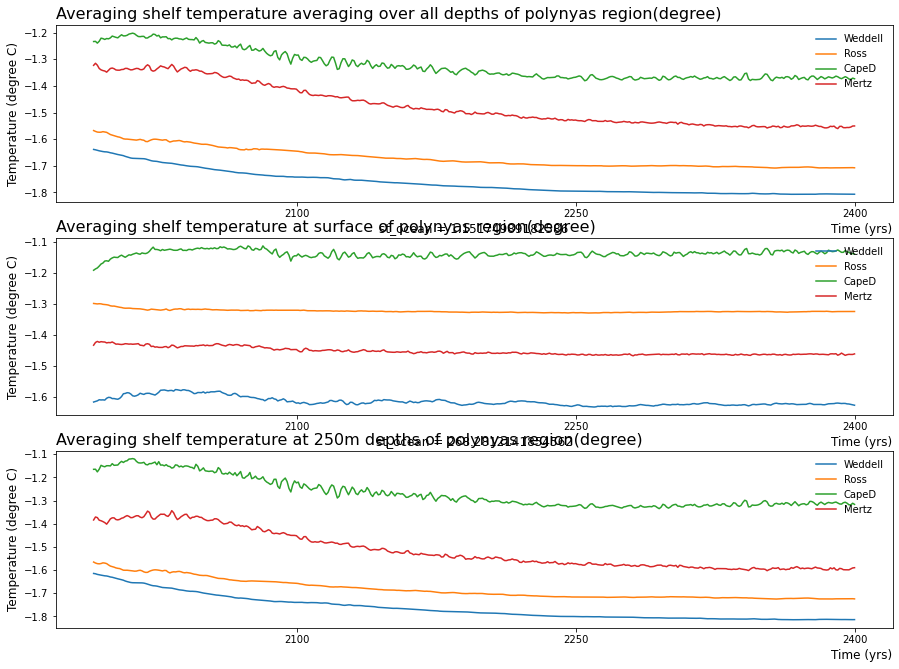

In [23]:
fig = plt.figure(figsize=(15, 15))

#Plotting mean shelf temperature at surface, 250m and averaging over all depths
plt.subplot(4,1,1)
plt.title('Averaging shelf temperature averaging over all depths of polynyas region(degree)', fontsize=16, loc='left')
temp_st_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
temp_st_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
temp_st_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
temp_st_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,2)
plt.title('Averaging shelf temperature at surface of polynyas region(degree)', fontsize=16, loc='left')
temp_surface_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
temp_surface_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
temp_surface_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
temp_surface_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,3)
plt.title('Averaging shelf temperature at 250m depths of polynyas region(degree)', fontsize=16, loc='left')
temp_250m_shelf_Weddell.mean(("xt_ocean","yt_ocean")).plot(label='Weddell')
temp_250m_shelf_Ross.mean(("xt_ocean","yt_ocean")).plot(label='Ross')
temp_250m_shelf_CapeD.mean(("xt_ocean","yt_ocean")).plot(label='CapeD')
temp_250m_shelf_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

Q: Whats the difference between 

temp_250m_shelf_Ross.mean(("xt_ocean", "yt_ocean"))

and

temp_250m_shelf_Ross.mean("xt_ocean").mean("yt_ocean")